# Multivariate Normal with NGBoost

**Problem**: Multi-output regression with correlated predictions — predict
multiple targets simultaneously and capture their joint uncertainty.

**When to use**:
- Multi-target forecasting: predict temperature AND humidity together
- Portfolio risk: joint distribution of multiple asset returns
- Spatial prediction: x and y coordinates with correlated errors
- Any problem where multiple outputs are correlated

**How it works**: `MultivariateNormal(k)` is a factory that creates a
distribution class for `k`-dimensional output. Parameters include
`k` mean components and `k(k+1)/2` Cholesky factor entries (covariance).

In [1]:
import sys
sys.path.insert(0, '..')  # add project root so 'import ngboost' finds the package

In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from ngboost import NGBRegressor
from ngboost.distns import MultivariateNormal

## 1. Generate synthetic correlated 2D data

In [3]:
np.random.seed(42)
n_samples = 1000
k = 2  # 2D output
X = np.random.randn(n_samples, 5)

# True means depend on features
true_mean = np.column_stack([
    2.0 + 1.0 * X[:, 0],
    -1.0 + 0.5 * X[:, 1],
])
# True covariance: correlated outputs
true_cov = np.array([[1.0, 0.6], [0.6, 0.8]])
L = np.linalg.cholesky(true_cov)
noise = np.random.randn(n_samples, k) @ L.T
Y = true_mean + noise

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Y shape: {Y.shape}")
print(f"Y[:,0] range: [{Y[:,0].min():.1f}, {Y[:,0].max():.1f}]")
print(f"Y[:,1] range: [{Y[:,1].min():.1f}, {Y[:,1].max():.1f}]")
print(f"True correlation: {np.corrcoef(Y[:,0], Y[:,1])[0,1]:.3f}")
print(f"Train: {len(Y_train)}, Test: {len(Y_test)}")

Y shape: (1000, 2)
Y[:,0] range: [-2.5, 6.1]
Y[:,1] range: [-4.2, 2.1]
True correlation: 0.407
Train: 800, Test: 200


## 2. Train NGBoost

`MultivariateNormal(k)` creates a distribution class for k-dimensional
output. It has `k * (k + 3) / 2` parameters (means + Cholesky entries).

In [4]:
MVN2 = MultivariateNormal(k)
print(f"n_params: {MVN2.n_params} (2 means + 3 Cholesky entries)")

tree_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=10,
    min_samples_leaf=3,
    max_depth=5,
    random_state=None,
)
ngb = NGBRegressor(
    Dist=MVN2,
    n_estimators=500,
    learning_rate=0.01,
    verbose=False,
    random_state=42,
    Base=tree_learner,
)
ngb.fit(X_train, Y_train)
print("Training complete.")

n_params: 5 (2 means + 3 Cholesky entries)
Training complete.


## 3. Predictions and covariance

In [5]:
dists = ngb.pred_dist(X_test)
Y_pred = ngb.predict(X_test)

print("Predicted means (first 3 test samples):")
print(f"  y0: {dists.loc[:3, 0].round(3)}")
print(f"  y1: {dists.loc[:3, 1].round(3)}")

print(f"\nPredicted (first 3): {Y_pred[:3].round(2)}")
print(f"Actual (first 3):     {Y_test[:3].round(2)}")

Predicted means (first 3 test samples):
  y0: [1.572 1.055 3.24 ]
  y1: [-1.01   0.031 -0.279]

Predicted (first 3): [[ 1.57 -1.01]
 [ 1.05  0.03]
 [ 3.24 -0.28]]
Actual (first 3):     [[ 4.02 -0.22]
 [-0.68 -0.45]
 [ 3.76 -1.2 ]]


## 4. Joint uncertainty — covariance and correlation

In [6]:
# Get scipy distribution objects to inspect covariance
scipy_dist = dists.scipy_distribution()

# Covariance for the first test sample
cov_0 = scipy_dist[0].cov
corr_0 = cov_0[0, 1] / np.sqrt(cov_0[0, 0] * cov_0[1, 1])
print(f"Test sample 0 — predicted covariance:")
print(f"  {cov_0.round(3)}")
print(f"  correlation: {corr_0:.3f} (true: {true_cov[0,1] / np.sqrt(true_cov[0,0] * true_cov[1,1]):.3f})")

Test sample 0 — predicted covariance:
  [[0.332 0.233]
 [0.233 0.227]]
  correlation: 0.849 (true: 0.671)


## 5. Visualize

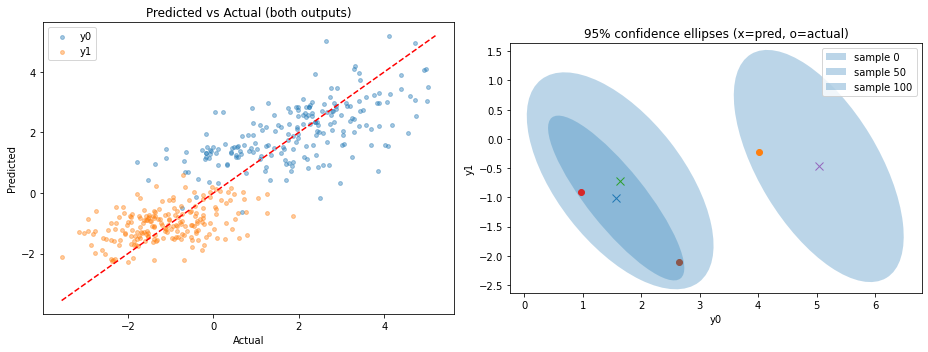

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: predicted vs actual for each output
ax = axes[0]
ax.scatter(Y_test[:, 0], Y_pred[:, 0], alpha=0.4, s=15, label="y0")
ax.scatter(Y_test[:, 1], Y_pred[:, 1], alpha=0.4, s=15, label="y1")
lims = [min(Y_test.min(), Y_pred.min()), max(Y_test.max(), Y_pred.max())]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Predicted vs Actual (both outputs)")
ax.legend()

# Right: joint distribution ellipses for 3 test samples
ax = axes[1]
for idx in [0, 50, 100]:
    mean = dists.loc[idx]
    cov = scipy_dist[idx].cov
    # Draw 95% confidence ellipse
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigvecs[1, 1], eigvecs[0, 1]))
    width, height = 2 * np.sqrt(5.991 * eigvals)  # 95% chi2 with 2 dof
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                  alpha=0.3, label=f"sample {idx}")
    ax.add_patch(ell)
    ax.plot(*mean, "x", markersize=8)
    ax.plot(*Y_test[idx], "o", markersize=6)
ax.set_xlabel("y0")
ax.set_ylabel("y1")
ax.set_title("95% confidence ellipses (x=pred, o=actual)")
ax.legend()
ax.set_aspect("equal")
ax.autoscale()

plt.tight_layout()
plt.show()